# Поиск частых наборов
Бадамшина Ангелина КЭ-403 

Разработайте программу, которая выполняет поиск частых наборов объектов в заданном наборе данных с помощью алгоритма Apriori (или одной из его модификаций). Список результирующих наборов должен содержать как наборы, так и значение поддержки для каждого набора. Параметрами программы являются набор, порог поддержки и способ упорядочивания результирующего списка наборов (по убыванию значения поддержки или лексикографическое).

Проведите эксперименты на наборе данных baskets.csv (сведения о покупках в супермаркете). В экспериментах варьируйте пороговое значение поддержки (например: 1%, 3%, 5%, 10%, 15%).

Выполните визуализацию результатов экспериментов в виде следующих диаграмм:
 - сравнение быстродействия на фиксированном наборе данных при изменяемом пороге поддержки;
 - количество частых наборов объектов различной длины на фиксированном наборе данных при изменяемом пороге поддержки.

Подготовьте отчет о выполнении задания и загрузите отчет в формате PDF в систему. Отчет должен представлять собой связный и структурированный документ со следующими разделами:  
 - формулировка задания;
 - гиперссылка на каталог репозитория с исходными текстами, наборами данных и др. сопутствующими материалами; 
 - рисунки с результатами визуализации; 
 - пояснения, раскрывающие смысл полученных результатов.

In [18]:
import pandas as pd
import chardet
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
import time
import matplotlib.pyplot as plt

In [55]:
# Определяем кодировку файла, чтобы избежать проблем с разными системами
with open('baskets.csv', 'rb') as f:  # Открываем файл в бинарном режиме
    result = chardet.detect(f.read())  # Определяем кодировку файла с помощью chardet

# Загружаем данные с корректной кодировкой
df = pd.read_csv('baskets.csv', encoding=result['encoding'])
df

,креветки,миндаль,авокадо,овощная смесь,зеленый виноград,цельнозерновая мука,батат,творог,энергетический напиток,томатный сок,низкокалорийный йогурт,зеленый чай,мед,салат,минеральная вода,лосось,ягодный сок,замороженный смузи,шпинат,оливковое масло
0,гамбургер,фрикадельки,яйца,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,чатни,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,индейка,авокадо,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,минеральная вода,молоко,энергетический батончик,рис,зеленый чай,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,низкокалорийный йогурт,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,сливочное масло,низкокалорийный майонез,свежий хлеб,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7496,гамбургер,замороженные овощи,яйца,картофель-фри,журнал,зеленый чай,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7497,курица,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7498,эскалоп,зеленый чай,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [60]:
# Функция для поиска частых наборов элементов с помощью Apriori
def find_frequent_itemsets(df, min_support, sort_by='support'):
    # Преобразуем данные в список списков (транзакции)
    transactions = df.values.tolist()  # Преобразуем DataFrame в список списков
    
    # Удаляем пропущенные значения (NaN) из транзакций
    transactions = [[item for item in transaction if not pd.isnull(item)] for transaction in transactions]

    # Кодируем транзакции в бинарную матрицу (разряженное представление)
    te = TransactionEncoder()  # Создаем объект TransactionEncoder
    te_transform = te.fit(transactions).transform(transactions)  # Преобразуем транзакции в бинарную матрицу
    transactions_matrix = pd.DataFrame(te_transform, columns=te.columns_)  # Преобразуем в DataFrame для удобства работы

     # Запускаем алгоритм Apriori для поиска частых наборов
    frequent_itemsets = apriori(transactions_matrix, min_support=min_support, use_colnames=True)  # Алгоритм Apriori

    # Сортируем результаты по поддержке или лексикографически
    if sort_by == 'support':
        frequent_itemsets = frequent_itemsets.sort_values(by='support', ascending=False)  # Сортируем по поддержке
    elif sort_by == 'lexical':
        frequent_itemsets = frequent_itemsets.sort_values(by='itemsets')  # Сортируем лексикографически

    return frequent_itemsets  # Возвращаем частые наборы



Алгоритм Apriori используется для поиска частых наборов объектов в наборе данных. Его работа основана на принципе априорной связи, который утверждает, что если некоторый набор объектов является частым, то любое его подмножество также должно быть частым.

In [61]:
# Минимальный уровень поддержки
min_support = 0.01 # Устанавливаем порог поддержки 1%

# Ищем частые наборы товаров
result = find_frequent_itemsets(df, min_support, sort_by='support')

# Отображаем топ-20 частых наборов
result.head(20)

,support,itemsets
31,0.238267,(минеральная вода)
26,0.188000,(макароны)
73,0.179733,(яйца)
20,0.170933,(картофель-фри)
69,0.163867,(шоколад)
17,0.132000,(зеленый чай)
32,0.129600,(молоко)
9,0.098267,(говяжий фарш)
15,0.095333,(замороженные овощи)
5,0.095067,(блинчики)


Согласно полученному результату и показателю support (мера того, насколько часто набор объектов встречается в наборе данных), наиболее популярными товарами являются "минеральная вода", "макароны" и "яйца"

In [45]:
# Фильтруем частые наборы с 2 элементами
result_with_2_items = result[result['itemsets'].apply(lambda x: len(x)) == 2]
result_with_2_items


,support,itemsets
185,0.061200,"(минеральная вода, макароны)"
213,0.052667,"(минеральная вода, шоколад)"
215,0.050933,"(минеральная вода, яйца)"
201,0.048000,"(минеральная вода, молоко)"
105,0.040933,"(минеральная вода, говяжий фарш)"
...,...,...
212,0.010267,"(минеральная вода, хлопья)"
237,0.010133,"(суп, шоколад)"
121,0.010133,"(низкокалорийный йогурт, замороженные овощи)"
154,0.010000,"(креветки, картофель-фри)"


In [46]:
# Фильтруем частые наборы с 3 элементами
result_with_3_items = result[result['itemsets'].apply(lambda x: len(x)) == 3]
result_with_3_items

,support,itemsets
247,0.017200,"(минеральная вода, макароны, говяжий фарш)"
256,0.016400,"(минеральная вода, макароны, шоколад)"
254,0.016133,"(минеральная вода, макароны, молоко)"
257,0.015200,"(минеральная вода, макароны, яйца)"
260,0.014000,"(минеральная вода, шоколад, молоко)"
262,0.013467,"(минеральная вода, шоколад, яйца)"
261,0.013067,"(минеральная вода, яйца, молоко)"
251,0.012267,"(минеральная вода, макароны, замороженные овощи)"
246,0.011733,"(минеральная вода, макароны, блинчики)"
258,0.011200,"(макароны, шоколад, молоко)"


# Построение графиков

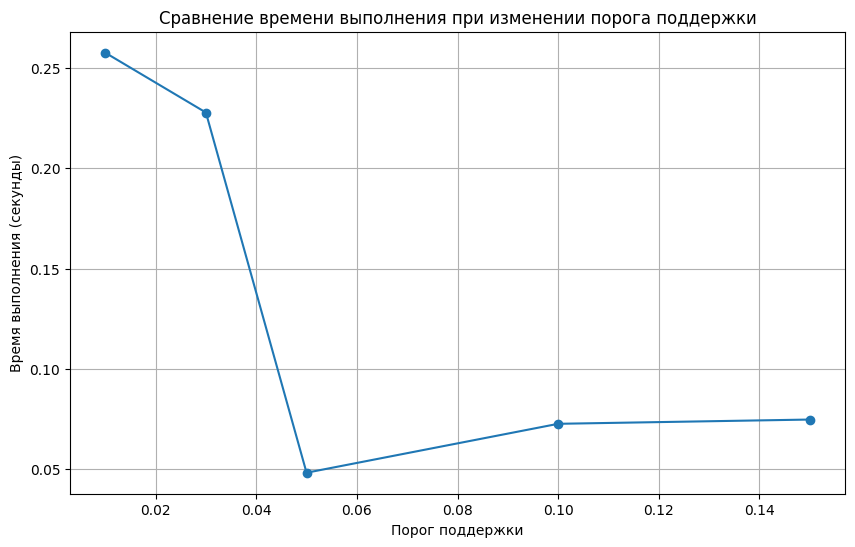

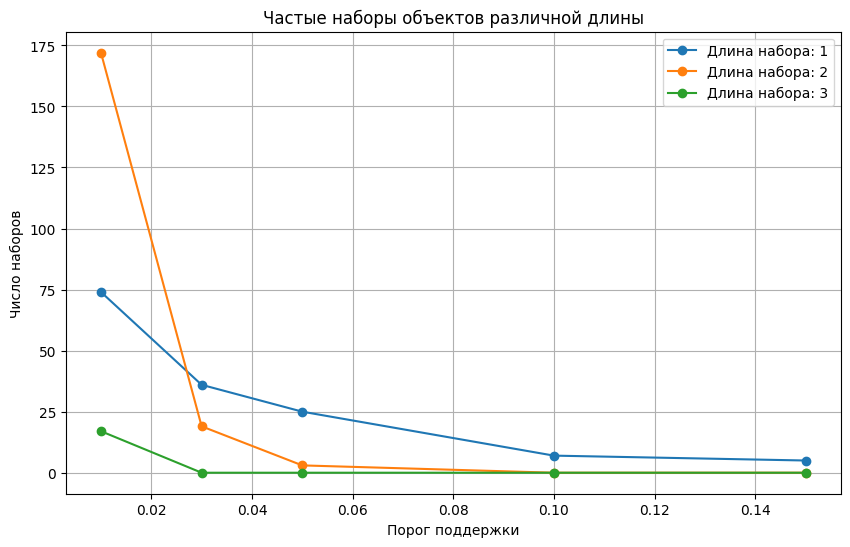

In [62]:
# Функция для измерения времени выполнения алгоритма
def measure_execution_time(data, min_support):
    start_time = time.time()  # Записываем начальное время
    find_frequent_itemsets(data, min_support)  # Запускаем поиск частых наборов
    end_time = time.time()  # Записываем конечное время
    return end_time - start_time  # Возвращаем разницу во времени (время работы алгоритма)

# Функция для построения графика зависимости времени работы от порога поддержки
def plot_execution_time(data, min_support_values):
    execution_times = [measure_execution_time(data, min_support) for min_support in min_support_values]  # Измеряем время для каждого порога

    # Строим график времени выполнения
    plt.figure(figsize=(10, 6))  # Устанавливаем размер графика
    plt.plot(min_support_values, execution_times, marker='o', linestyle='-')  # Строим график
    plt.title('Сравнение времени выполнения при изменении порога поддержки')  # Заголовок графика
    plt.xlabel('Порог поддержки')  # Подпись оси X
    plt.ylabel('Время выполнения (секунды)')  # Подпись оси Y
    plt.grid(True)  # Добавляем сетку
    plt.show()  # Отображаем график

    
# Функция для построения графика зависимости количества частых наборов от их длины
def plot_frequent_itemset_length(data, min_support_values):
    supports = []  # Список для хранения значений порога поддержки
    length_counts = {}  # Словарь для хранения количества наборов разной длины

    # Перебираем различные уровни поддержки
    for min_support in min_support_values:
        frequent_itemsets = find_frequent_itemsets(data, min_support)  # Ищем частые наборы для текущего порога
        counts = frequent_itemsets['itemsets'].apply(len).value_counts().sort_index()  # Считаем количество наборов разной длины

        # Добавляем новые длины наборов в словарь, если они появляются впервые
        for length in counts.index:
            if length not in length_counts:
                length_counts[length] = [0] * len(supports)  # Заполняем нулями предыдущие значения

        # Заполняем данные по текущему уровню поддержки
        for length in length_counts.keys():
            length_counts[length].append(counts.get(length, 0))  # Если нет данных, добавляем 0

        supports.append(min_support)  # Добавляем текущий порог поддержки

  # Строим график
    plt.figure(figsize=(10, 6))  # Устанавливаем размер графика
    for length, counts in length_counts.items():  # Для каждой длины набора строим линию
        plt.plot(supports, counts, marker='o', linestyle='-', label=f'Длина набора: {length}')  # Строим график для длины набора

    plt.xlabel('Порог поддержки')  # Подпись оси X
    plt.ylabel('Число наборов')  # Подпись оси Y
    plt.title('Частые наборы объектов различной длины')  # Заголовок графика
    plt.legend()  # Легенда для графика
    plt.grid(True)  # Добавляем сетку
    plt.show()  # Отображаем график

# Определяем разные уровни поддержки для эксперимента
min_support_values = [0.01, 0.03, 0.05, 0.10, 0.15]  # Устанавливаем несколько уровней поддержки для эксперимента

# Строим график времени выполнения алгоритма для разных уровней поддержки
plot_execution_time(df, min_support_values)  # Строим график зависимости времени от порога поддержки

# Строим график количества частых наборов разной длины для разных уровней поддержки
plot_frequent_itemset_length(df, min_support_values)  # Строим график зависимости количества наборов от их длины

На первом графике показано, как изменяется время выполнения алгоритма Apriori в зависимости от установленного порога поддержки. Видно, что при снижении порога поддержки вычисления занимают больше времени, так как алгоритму требуется обрабатывать больше возможных комбинаций.
Второй график показывает количество частых наборов различных длин при разных значениях поддержки. Чем ниже порог поддержки, тем большее количество частых наборов обнаруживается. Однако при высоких значениях поддержки остаются только самые популярные сочетания товаров.